In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
plt.figure()
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'font.size': 12})
plt.rc('axes', axisbelow=True)

<Figure size 432x288 with 0 Axes>

# 1. From Scatch

### 1A. load data

In [3]:
from pathlib import Path
import requests

In [12]:
# create dir: '/Users/yang/.../repo/mydata'
DATA_PATH = Path('my_data')
DATA_PATH.mkdir(exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (DATA_PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (DATA_PATH/FILENAME).open('wb').write(content) # download to my own dir!

In [13]:
import pickle 
import gzip

In [396]:
# load pickle file and assign to train/test data
with gzip.open((DATA_PATH/FILENAME).as_posix(), 'rb') as f:
    ((X_train, y_train), (X_val, y_val), _) = pickle.load(f, encoding='latin-1')
print(X_train.shape)

(50000, 784)


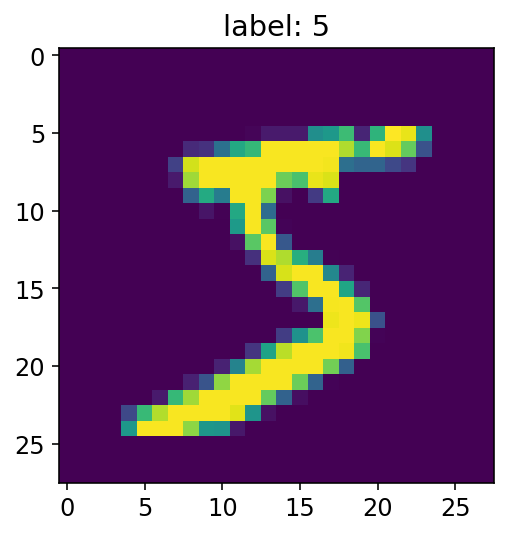

In [397]:
# visualize one sample
plt.imshow(X_train[0].reshape(28,28))
plt.title('label: ' + str(y_train[0]))
plt.show()

In [398]:
import torch

# convert nd array to torch.Tensor. map(func, iter) applies function to each item of iterable
X_train, y_train, X_val, y_val = map(torch.Tensor, (X_train, y_train, X_val, y_val))
print(X_train.shape)
print(y_train.unique())

torch.Size([50000, 784])
tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])


### 1B. Build NN from scratch!

In [399]:
# initialize weights with N(0,1)
dim_feature = X_train.shape[1] # N feature
n_out = 10 # 10 labels
W = torch.randn(dim_feature, n_out) / np.sqrt(dim_feature) # xavier instantiation
W.requires_grad = True # require grad here because we did a computation before; don't want that in gradient
b = torch.zeros(n_out, requires_grad=True) # bias

In [400]:
# SoftMax
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1) # sum(-1): sum along last dimension. unsqueeze: remain original shape

# forward pass; returns prediction after softmax; dim = batch_size by 10. 
def model(x):
    return log_softmax(x @ W + b)

# accuracy
def accuracy(preds, y_true):
    preds = torch.argmax(preds, dim=1) # for each row, find idx of max value
    return (preds == y_true).float().mean()

In [401]:
# run forward pass on a batch
bs = 64 # batch size

preds = model(X_train[0:bs])
print(preds[0])
print(preds.shape)

# get true label
yb = y_train[0:bs]
print(yb.shape)

tensor([-2.8775, -2.1693, -2.9060, -2.0242, -2.6761, -2.1136, -1.6464, -2.0687,
        -2.6672, -2.7406], grad_fn=<SelectBackward>)
torch.Size([64, 10])
torch.Size([64])


In [402]:
# loss: find log(softmax) at indices where y_true is non-zero. Average over the batch. 
def loss_func(pred, true):
    return -pred[range(true.shape[0]), np.array(true.int())].mean()

# loss_func = nll
print(loss_func(preds, yb))
print(accuracy(preds, yb))

tensor(2.4007, grad_fn=<NegBackward>)
tensor(0.0625)


### 1C. Training

In [403]:
# train!

bs = 64
lr = 0.5
epochs = 2
n_tot = X_train.shape[0]
for epoch in range(epochs):
    for i in range((n_tot-1)//bs+1):
        start_idx = i*bs
        end_idx = (i+1)*bs
        
        xb = X_train[start_idx:end_idx]
        yb = y_train[start_idx:end_idx]
        
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad(): # do not track grad from 'W -='
            # do gradient descent
            W -= lr*W.grad  # WARNING: must use 'W -=' for IN-PLACE calculation, not 'W = W - ...' 
            b -= lr*b.grad 
            W.grad.zero_()
            b.grad.zero_()

In [404]:
print(loss_func(model(X_train[start_idx:end_idx]), y_train_batch), accuracy(model(X_train[start_idx:end_idx]), y_train_batch))

tensor(0.0835, grad_fn=<NegBackward>) tensor(1.)


# 2. Refactor the code!

### nn.functional

In [447]:
import torch.nn.functional as F
loss_func = F.cross_entropy
y_train = y_train.type(torch.LongTensor) # some losses require LongTensor type
yb = yb.type(torch.LongTensor)

In [448]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0812, grad_fn=<NllLossBackward>) tensor(1.)


### nn.Module, nn.Parameter

In [449]:
from torch import nn

class mnist_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.W = nn.Parameter(torch.randn(784, 10)/np.sqrt(n_tot))
        self.b = nn.Parameter(torch.zeros(10))
        
    def forward(self, x):
        return x @ self.W + self.b

# instantiation
model = mnist_model()

In [450]:
X_train.shape

torch.Size([50000, 784])

In [451]:
# when caling model(X_train), X is automatically passed to the forward layer and returned
loss_func(model(X_train[:1000]), y_train[:1000])

tensor(2.3071, grad_fn=<NllLossBackward>)

In [452]:
def train():
    for epoch in range(epochs):
        for i in range((n_tot-1)//bs+1):
            start = i * bs
            end = (i+1)*bs
            xb = X_train[start:end]
            yb = y_train[start:end]
            
            pred = model(xb)
            loss = loss_func(pred, yb)
            
            loss.backward()
            with torch.no_grad():
                for param in model.parameters():
                    param -= lr * param.grad
                model.zero_grad()

In [453]:
train()

In [454]:
print(loss)

tensor(0.3206, grad_fn=<NegBackward>)


### nn.Linear

In [463]:
# could replace x @ W + b by a linear layer from torch.nn!

class model_mnist(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
        
    def forward(self, x):
        return self.lin(x)
    
model = model_mnist()

In [465]:
loss_func(model(X_train[:1000]), y_train[:1000])

tensor(2.2930, grad_fn=<NllLossBackward>)

In [473]:
train()
loss_func(model(X_train[:1000]), y_train[:1000])

tensor(0.2864, grad_fn=<NllLossBackward>)

### nn.optim

In [471]:
# could replace the gradient-updating step by optim.step()!
from torch import optim

model = model_mnist()
opt = optim.SGD(params=model.parameters(), lr=0.5)

for epoch in range(epochs):
    for i in range((n_tot - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = X_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0818, grad_fn=<NllLossBackward>)


# Dataset, DataLoader

In [479]:
# Dataset should support __len__ and __getitem__
from torch.utils.data import TensorDataset

train_data = TensorDataset(X_train, y_train)
xb, yb = train_data[0:2000]
print(xb.shape, yb.shape)

torch.Size([2000, 784]) torch.Size([2000])


In [481]:
# DataLoader manages batches and can be constructed from Dataset
from torch.utils.data import DataLoader

train_data = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_data, batch_size = bs)

In [483]:
# then we can directly loop over batches!

model = model_mnist()
opt = optim.SGD(params=model.parameters(), lr=0.5)

for epoch in range(epochs):
    for xb, yb in train_dataloader: # xb, yb are already from a batch!
        pred = model(xb)
        loss = loss_func(pred, yb)
        loss.backward()
        
        opt.step()
        opt.zero_grad()
        
print(loss_func(model(xb), yb))

tensor(0.0826, grad_fn=<NllLossBackward>)


In [496]:
# now could combine with validation dataset. Need to shuffle training set, no need to shuffle validation set.

train_data = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_data, batch_size=bs, shuffle=True)

val_data = TensorDataset(X_val, y_val)
val_dataloader = DataLoader(val_data, batch_size=2*bs) # no backprop, so large batch is fine

In [497]:
model = model_mnist()
opt = optim.SGD(params=model.parameters(), lr=0.5)

for epoch in range(epochs):
    model.train() # ensures good behaviror for e.g. dropout, batchnorm
    for xb, yb in train_dataloader:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval() # ensures good behaviror for e.g. dropout, batchnorm
    with torch.no_grad():
        validation_loss = np.sum(loss_func(model(xb), yb.type(torch.LongTensor)) for xb, yb in val_dataloader)
    print('validation_loss: ' + str(validation_loss/len(val_data)))

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  app.launch_new_instance()


validation_loss: tensor(0.0024)
validation_loss: tensor(0.0027)


# 3. Full PyTorch style!

In [18]:
import torch
from torch import nn, optim
from torch.functional import F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets # this module has existing vision data, e.g. MNIST, CIFAR10, etc
from torchvision.transforms import ToTensor

In [8]:
# read MNIST datasets from torchvision
data_train = datasets.EMNIST(root='data', download=True, train=True, split='mnist', transform=ToTensor())
data_val = datasets.EMNIST(root='data', download=True, train=False, split='mnist', transform=ToTensor())
data_test = datasets.EMNIST(root='data', download=True, train=False, split='mnist', transform=ToTensor())

In [9]:
# load the datasets with dataloader
batch_size = 64
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True) # if shuffle, the sample will be differnet for each iteration!
dataloader_val = DataLoader(data_val, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

dimension of X: torch.Size([64, 1, 28, 28])


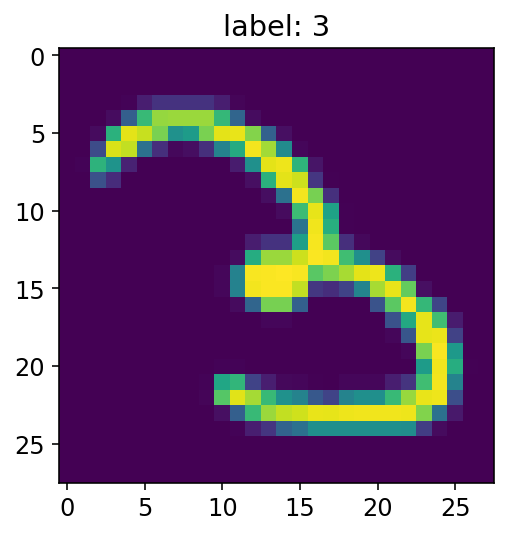

In [17]:
# obtain one batch and visualize the first element
# dimension of X: (batch_size, n_channel, height, width), where 1 is the chanel. 
for X, y in dataloader_train:
    print('dimension of X: ' + str(X.shape))
    plt.imshow(X[0][0,:,:].T)
    plt.title('label: ' + str(np.array(y[0])))
    break

In [24]:
class model_cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1) # in_channel, out_channel
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28) # the first dimension (batch size) is inferred
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.avg_pool2d(x, 4)
        return x.view(-1, x.size(1))

In [28]:
lr = 0.1
epochs = 2

model = model_cnn()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
loss_func = F.cross_entropy

In [32]:
for epoch in range(epochs):
    model.train()
    for xb, yb in dataloader_train:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        opt.zero_grad()
        loss.backward()
        
        opt.step()
        
    model.eval()
    val_score = np.sum(loss_func(model(xb), yb) for xb, yb in dataloader_val) / len(data_val)
    print(epoch, val_score)

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  del sys.path[0]


0 tensor(0.0025, grad_fn=<DivBackward0>)
1 tensor(0.0023, grad_fn=<DivBackward0>)
